# Sprint4 ロジスティック回帰

In [18]:
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
sns.set()
%matplotlib inline

In [189]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def scores(y_test,y_pred):
    print(accuracy_score(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))

In [717]:
# iris data set
from sklearn.datasets import load_iris
iris = load_iris()
#print(iris)

X_df = pd.DataFrame(iris.data,columns=iris.feature_names)

y_df = pd.DataFrame(iris.target,columns={'Species'})
df = pd.concat([X_df, y_df], axis=1)

#'virgicolor,'virginica'だけ抜き出す
aaa = df.query('Species == [1, 2]')
# print(aaa.head(3))
# aaa[aaa['Species']==1]= 'virgicolor' #名前 を 0,1,2 から setosa,virgicolor,virginica に変更
# aaa[aaa['Species']==2]= 'virginica'

X = aaa.drop('Species',axis=1).iloc[:, :2].values  #4つ突っ込んでも大丈夫
X_new_df = pd.DataFrame(X,columns=iris.feature_names[:2])
# print(X_new_df)
y = aaa.loc[:,['Species']].values - 1 #1,2 ->0,1
y_new_df = pd.DataFrame(y,columns={'Species'})
y_new_df[y_new_df['Species']==0]= 'virgicolor' #名前 を 0,1,2 から setosa,virgicolor,virginica に変更
y_new_df[y_new_df['Species']==1]= 'virginica'
# print(y_new_df)

In [718]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,
                                                   stratify=y)

In [719]:
# def MSE(y_pred, y):
#     error_mse = y_pred - y   
#     mse = np.sum(error_mse **2) /len(y)
#     return mse #Sprint3,問題４
#これに変わる目的関数を問題４で作成

class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,) #thetaのこと
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter=500000, lr=0.001, 
                 lam = 5,
                 bias=True, verbose=True):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.theta = None
        self.lam = lam #ラムダを追加
    
    #問題1
    def _linear_hypothesis(self, X):
        return np.dot(self.theta, X.T).reshape(len(X),1)

    def _logistic_hypothesis(self, X):
        lh = self._linear_hypothesis(X)
        sigmoid = 1/ (1+ np.exp(-lh)) #ネイピア数
        return sigmoid    
    #問題1
    
    #問題２
    def _gradient_descent(self, X, error):
        self.theta[0]= self.theta[0] - self.lr* (np.mean(error*X , axis = 0)) 
        self.theta[1:]= self.theta[1:]- self.lr* ((np.mean(error*X , axis = 0)) + self.lam / X.shape[0] * self.theta[1:])
    #問題２
    #改行ミスでエラー
    
    def _Loss(self, y_proba,y):  
        theta = np.delete(self.theta, 0) #切片を落とす
        loss = (np.sum(- y* np.log(y_proba)-(1-y)* np.log(1- y_proba))/y_proba.shape[0]) + np.sum(theta**2) *self.lam /(2*y_proba.shape[0])
        return loss    

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        if self.bias:
            X = np.insert(X,0,1,axis=1) #一行目に１のみのx0を追加         
            if X_val is not None:
                X_val = np.insert(X_val,0,1,axis=1)
        
        np.random.seed(seed=9)
        self.theta = np.random.rand(1,X.shape[1]) #theta 初期値   
        
        for i in range(self.iter):                
            error = self._logistic_hypothesis(X) - y
            self._gradient_descent(X, error)
            y_proba = self._logistic_hypothesis(X)
            loss = self._Loss(y_proba, y)
            self.loss[i] =loss #問題4
            
            if X_val is not None:
                y_val_proba = self._logistic_hypothesis(X_val)
                loss_val = self._Loss(y_val_proba, y_val)
                self.val_loss[i] = loss_val #問題4　#X_val=None, y_val=None
        
        if self.verbose == True:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)
            if y_val is not None:
                print(self.val_loss)


    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        y_proba= self.predict_proba(X)   
        #0.5の上下で0,1(どちらに分類されるか)
        y_pred = np.where(y_proba < 0.5, 0, 1)
        return y_pred

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias:
            X = np.insert(X,0,1,axis=1) #一行目に１のみのx0を追加
            
        y_proba = self._logistic_hypothesis(X)        
        return y_proba

In [720]:
#問題３,6
slr = ScratchLogisticRegression()
slr.fit(X_train,y_train,X_val=X_test, y_val=y_test)

[2.22757115 2.21667283 2.20578623 ... 0.60593039 0.60593036 0.60593034]
[2.14403978 2.13342124 2.12281599 ... 0.81125417 0.81125438 0.81125458]


In [721]:
slr.predict(X_test)

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [696]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 0, solver='lbfgs',
                        multi_class = 'multinomial')
clf.fit(X_train,y_train)

/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [697]:
y_pred_sk = clf.predict(X_test)
y_proba_sk = clf.predict_proba(X_test)
accuracy_score(y_test, y_pred_sk)

0.76

In [698]:
slr.theta

array([[-6.27215273,  1.14117767, -0.2543825 ]])

0.52
[[ 0 12]
 [ 0 13]]


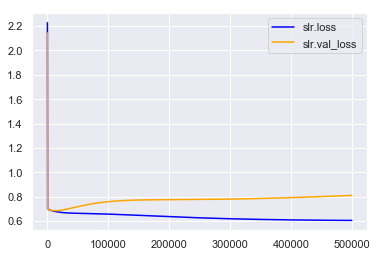

In [722]:
#問題７
plt.plot(slr.loss,label='slr.loss', color = 'blue')
plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()


scores(y_test, y_pred)
#accuracy　０.５に近いと微妙

#初期値変えて(乱数のnpの seed値を変えてみる)　->変化なし

In [709]:
y_train.shape

(75, 1)

In [723]:
# y_train

In [711]:
#問題８
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

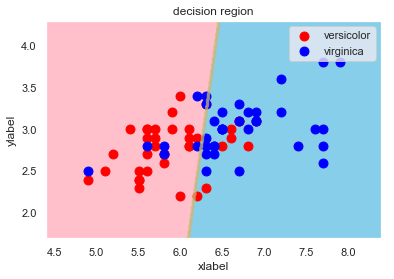

In [724]:
decision_region(X_train, y_train.ravel(), slr, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])

In [627]:
# x_array = np.insert(X,0,1,axis=1) #一行目に１のみのx0を追加
# theta = np.random.rand(1,x_array.shape[1]) #theta 初期値   
# the0 = np.delete(theta, 0)
# print(theta)
# print(the0)
# print(x_array)

# X_t_test = np.insert(X_test,0,1,axis=1)
# # x_array = np.insert(X_train,0,1,axis=1) #一行目に１のみのx0を追加
# y_pred = slr._linear_hypothesis(X_t_test)
# # print(X_t_test.shape)
# # print(y_pred.shape)

# def _linear_hypothesis(X):
#     return np.dot(theta, X.T).reshape(len(X),1)
    
# def _logistic_hypothesis(X):
#     lh = _linear_hypothesis(X)
#     sigmoid = 1/ (1+ np.exp(-lh)) #ネイピア数
#     return sigmoid    
#     #問題1
    
# li_a = _linear_hypothesis(x_array)
# y_proba = _logistic_hypothesis(x_array)
# print(li_a)
# print(y_proba)

# # 

# y_pred = _logistic_hypothesis(X_t_test)
# print(y_pred)

# print(np.log(y_pred))
# print(-(y_test* np.log(y_pred))-((1-y_test)* np.log(1- y_pred)))
# print(np.sum(- y_test* np.log(y_pred)-(1-y_test)* np.log(1- y_pred)))
# print(- y_test* np.log(y_pred)-(1-y_test)* np.log(1- y_pred))


## 【問題1】仮定関数

In [74]:
 x_array = np.insert(X,0,1,axis=1) #一行目に１のみのx0を追加
self.theta = np.random.rand(1,x_array.shape[1]) #theta 初期値   

def _linear_hypothesis(self,X):
        return np.dot(self.theta, X.T).reshape(len(X),1)
    
def _logistic_hypothesis(self, X):
    e = math.e #ネイピア数
    sigmoid = 1/ (1+ 1/e**(self._linear_hypothesis(X)))
    return sigmoid    

NameError: name 'self' is not defined

## 【問題2】最急降下法

In [75]:
#試作１
def _gradient_descent(self, X, error): 
#         print(self.theta.shape)
        j_part = self.theta - self.lr* np.sum(error*X , axis = 0)/X.shape[0] 
        #切片       
#         print(self.theta)
        self.theta = j_part + (self.lam / X.shape[0] * self.theta) #問題２
        self.theta[0,0]=j_part #theta0の時変わらないようにして。    
#         print(self.theta)

In [76]:
#試作２
def _gradient_descent(self, X, error): 
#         print(self.theta.shape)
        theta_zero = self.theta - np.sum(error*X , axis = 0)/X.shape[0] #切片
        self.theta = self.theta - self.lr*((np.sum(error*X , axis = 0)
                              /X.shape[0])+(coef_/X.shape[0]*theta))#問題２
#         print(self.theta)
        self.theta[0,0] = theta_zero[0,0] #切片をx０部分に代入
#         print(self.theta)

## 【問題4】目的関数

In [71]:
lam = 10
def _Loss(y_proba,y):
    
    loss = (np.sum(- y* np.log(y_proba)-(1-y)* np.log(1- y_proba))
            /y_proba.shape[0]) + (np.sum(theta**2) *lam /(2*y_proba.shape[0]))
          
    return loss

_Loss(y_pred,y_test)

/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


NameError: name 'theta' is not defined